In [1]:
import numpy as np
import pandas as pd
from re import sub
from time import time

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras_tqdm import TQDMNotebookCallback as ktqdm
from keras.utils import normalize
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import TensorBoard
from keras.optimizers import Adam, SGD

from tensorflow.nn import relu, softmax

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score

import scipy.stats as st

import seaborn as sns

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [26]:
df = pd.read_csv('fifa19.csv')

In [27]:
df.drop(columns=['Unnamed: 0', 'ID', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Preferred Foot',
                 'Body Type', 'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until'],inplace=True)

## Obiettivo: predire valore dei giocatori

Pre-processing: convertire value, wage e release clause da string a float

In [28]:
curs=["Release Clause", "Value", "Wage"]

for cur in curs:
    def curr2val(x):
        x = str(x).replace('€', '')
        if 'K' in x: x = float(str(x).replace('K', '')) * 1000
        else: x = float(str(x).replace('M', '')) * 1000000
        return x
    df[cur] = df[cur].apply(curr2val)
    

Individuare eventuali outlier nella colonna value

In [29]:
def detect_outlier(data, threshold = 3):
    outliers=[]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        score= (y - mean) / std 
        if np.abs(score) > threshold:
            outliers.append(y)
    return outliers

In [30]:
min_out = min(detect_outlier(df['Value'], threshold = 2))

df = df[df['Value'] < min_out] 
df = df[df['Value'] > 0]

Conversione in interi per le altre label

In [31]:
cols=["LS", "ST", "RS", "LW", "LF", "CF", "RF", "RW","LAM", "CAM", "RAM", "LM", "LCM", "CM", "RCM", "RM", "LWB", "LDM","CDM", "RDM", "RWB", "LB", "LCB", "CB", "RCB", "RB"]
for col in cols:
    df[col] = df[col].str[:-2]
    df[col] = df[col].astype(float)

In [32]:
df['Height'] = df['Height'].str.replace("'",'.')
df['Height'] = df['Height'].astype(float)

df['Weight'] = df['Weight'].str[:-3]
df['Weight'] = df['Weight'].astype(float)

Calcolo correlazione tra i valori per scegliere colonne significative

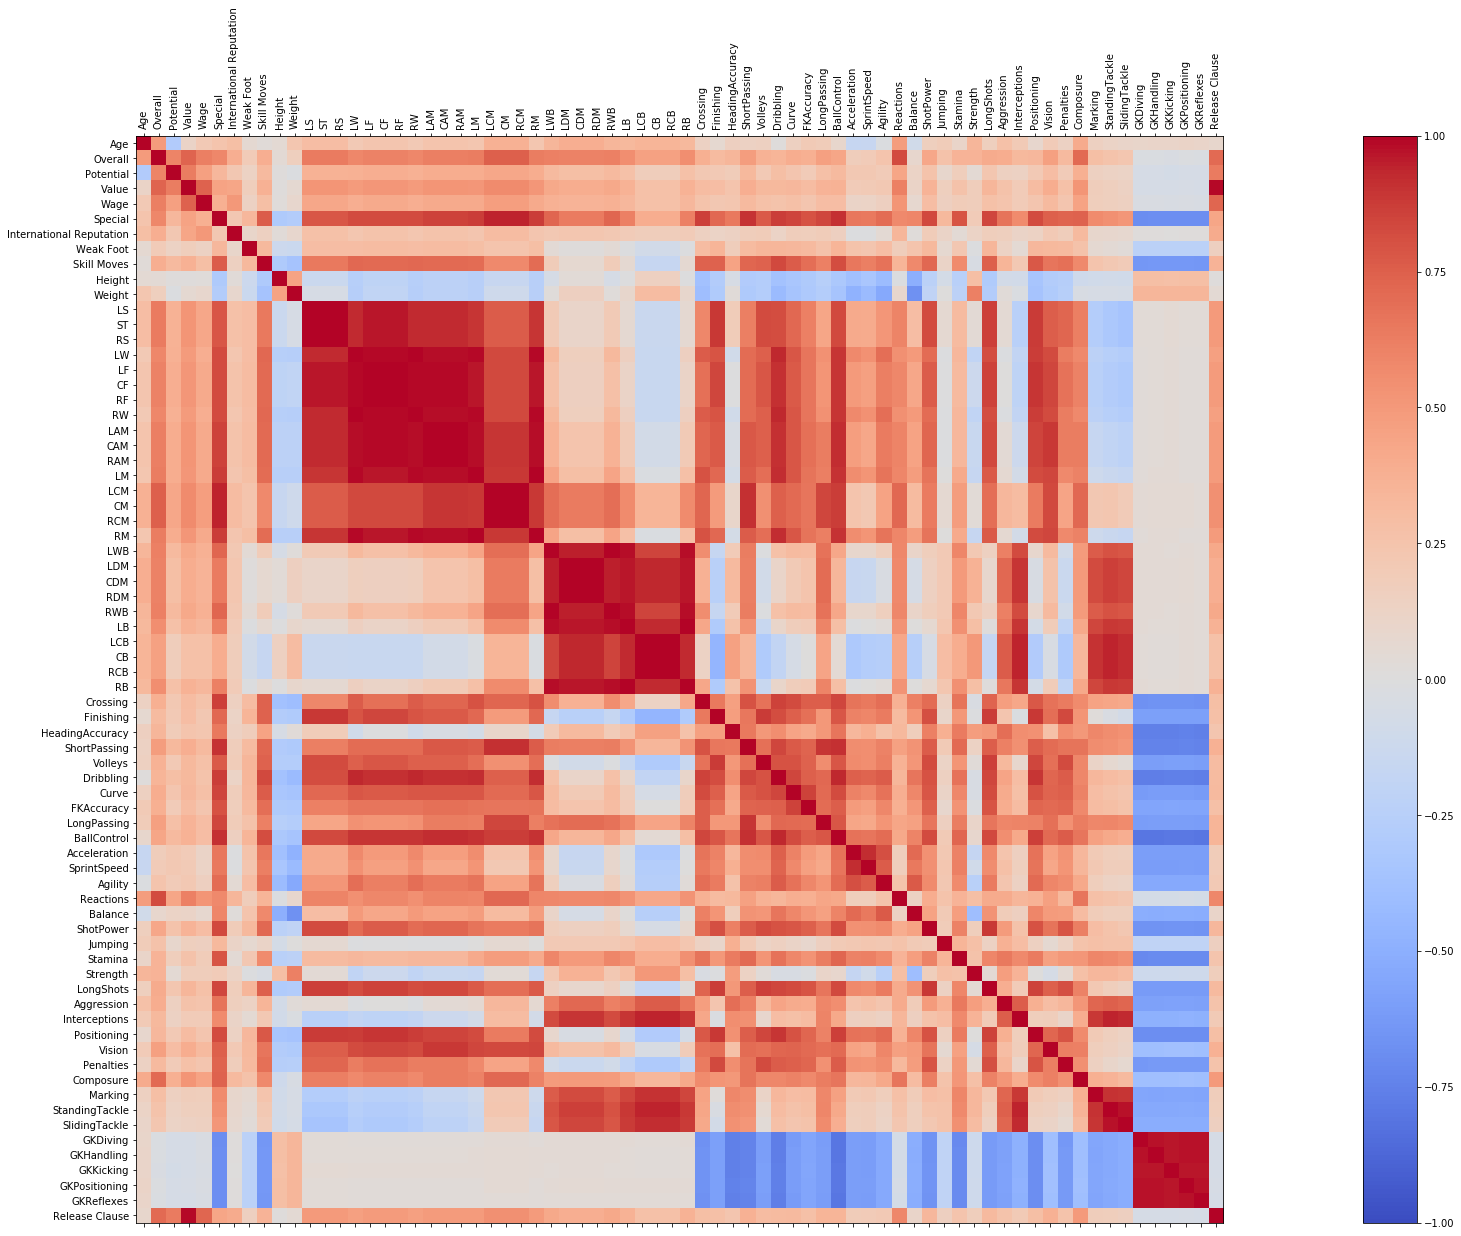

In [33]:
df_corr = df.corr()

fig = plt.figure(figsize=(50,20))
ax = fig.add_subplot(111)
cax = ax.matshow(df_corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0,len(df_corr.columns),1)
ax.set_xticks(ticks)
ax.set_xticklabels(df_corr.columns)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(df_corr.columns)

plt.show()

In [34]:
labels = []
for label in df_corr:
#     if df_corr['Value'][label] < 0 or df_corr['Value'][label] > 0.5: labels.append(label)
    if df_corr['Value'][label] > 0.6: labels.append(label)
        
df_flt = df[labels]        
df_flt.head()      

,Overall,Potential,Value,Wage,Reactions,Release Clause
41,88,88,4000000.0,77000.0,79.0,7400000.0
102,85,85,9000000.0,38000.0,85.0,15300000.0
108,85,85,9000000.0,57000.0,83.0,17100000.0
152,84,84,4200000.0,95000.0,80.0,6900000.0
201,83,83,13000000.0,70000.0,78.0,24700000.0


Divido in training e testing set

In [35]:
train_perc = 0.85
train_slice = int(len(df_flt) * train_perc)

df_flt = df_flt.sample(frac=1)

train = df_flt.iloc[:train_slice, :]
test = df_flt.iloc[train_slice:, :]

len(train), len(test)

(14799, 2612)

In [36]:
y_train = train.loc[:, ['Value']]
X_train = train.drop(columns='Value')

y_test = test.loc[:, ['Value']]
X_test = test.drop(columns='Value')

Sostiuisco eventuali valori nan con la media della colonna

In [37]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(X_train)
X_train = imputer.transform(X_train)

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(y_train)
y_train = imputer.transform(y_train)

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(X_test)
X_test = imputer.transform(X_test)

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(y_test)
y_test = imputer.transform(y_test)

Scalo i valori, sia per i caratteri che per il target

In [38]:
# scaler = RobustScaler()
# scaler = scaler.fit(X_train)
# X_train = scaler.transform(X_train)

# X_train_scaled = preprocessing.scale(X_train)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler_train = StandardScaler().fit(y_train)
y_train_scaled = scaler_train.transform(y_train) 
# X_train_scaled, X_test_scaled


scaler = StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)

scaler_test = StandardScaler().fit(y_test)
y_test_scaled = scaler_test.transform(y_test) 

Estraggo i sottoinsiemi per training e validation

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size = 0.15, random_state = 42)

In [40]:
def coeff_determination(y_test, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_test-y_pred ))
    SS_tot = K.sum(K.square( y_test - K.mean(y_test) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

In [41]:
def build_nn(neurons):
    model = Sequential()
    # Adding the input layer and the first hidden layer
    model.add(Dense(300, activation = 'relu', input_dim = neurons))
#     model.add(Dropout(0.01))
    
    # Adding the second hidden layer
    model.add(Dense(256, activation = 'relu'))
#     model.add(Dropout(0.01))
    
    # Adding the third hidden layer
    model.add(Dense(128, activation = 'relu'))

    # Adding the output layer
    model.add(Dense(1, activation = 'linear'))
    
    return model

In [42]:
nn = build_nn(X_train.shape[1])

In [43]:
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300)               1800      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 111,881
Trainable params: 111,881
Non-trainable params: 0
_________________________________________________________________


In [44]:
ts_board = TensorBoard(log_dir='value_predictions/{}'.format(time()))

In [45]:
opt = Adam(lr=0.001, beta_1=0.75, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=False)
# opt = SGD(lr=0.01, momentum=0.9)

nn.compile(optimizer = opt, loss = 'mean_absolute_error', metrics = [coeff_determination])

history = nn.fit(X_train, y_train, batch_size=125, epochs=50, callbacks=[ts_board], validation_data=(X_val, y_val), shuffle=True)

Train on 12579 samples, validate on 2220 samples
Epoch 1/50
12579/12579 [==============================] - 1s 45us/step - loss: 0.1616 - coeff_determination: 0.8559 - val_loss: 0.0956 - val_coeff_determination: 0.9360
Epoch 2/50
12579/12579 [==============================] - 0s 31us/step - loss: 0.0959 - coeff_determination: 0.9398 - val_loss: 0.0932 - val_coeff_determination: 0.9495
Epoch 3/50
12579/12579 [==============================] - 0s 31us/step - loss: 0.0925 - coeff_determination: 0.9463 - val_loss: 0.0842 - val_coeff_determination: 0.9495
Epoch 4/50
12579/12579 [==============================] - 0s 31us/step - loss: 0.0868 - coeff_determination: 0.9485 - val_loss: 0.0833 - val_coeff_determination: 0.9548
Epoch 5/50
12579/12579 [==============================] - 0s 33us/step - loss: 0.0871 - coeff_determination: 0.9509 - val_loss: 0.0979 - val_coeff_determination: 0.9428
Epoch 6/50
12579/12579 [==============================] - 0s 33us/step - loss: 0.0822 - coeff_determinatio

Epoch 49/50
12579/12579 [==============================] - 0s 34us/step - loss: 0.0571 - coeff_determination: 0.9806 - val_loss: 0.0638 - val_coeff_determination: 0.9792
Epoch 50/50
12579/12579 [==============================] - 0s 35us/step - loss: 0.0564 - coeff_determination: 0.9811 - val_loss: 0.0545 - val_coeff_determination: 0.9853


In [46]:
def mean_abs_error(prediction, target):
    res = 0
    tot = 0
    for i in range(len(target)):
        if target[i][0] != 0 and not np.isnan(prediction[i][0]):
#             print(prediction[i][0], target[i][0])
            res += abs(prediction[i][0] - target[i][0])
            tot += 1
    print(tot, len(target), len(prediction))
    return round(res / tot, 2)

In [47]:
res = nn.predict(X_test_scaled)
res = scaler_train.inverse_transform(res)
mean_abs_error(res, y_test), max(y_test), round(r2_score(y_test, res), 4)

2612 2612 2612


(159714.13, array([13500000.]), 0.981)

In [48]:
loss, acc = nn.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', acc)

2612/2612 [==============================] - 0s 32us/step
Test loss: 0.05869239653427878
Test accuracy: 0.980111993472755


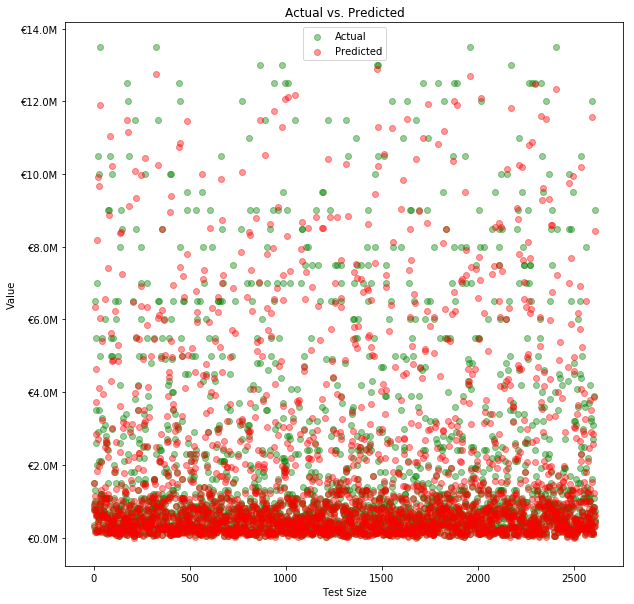

In [49]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x = range(0, y_test.size), y=y_test, c = 'green', label = 'Actual', alpha = 0.4)
ax.scatter(x = range(0, res.size), y=res, c = 'red', label = 'Predicted', alpha = 0.4)
plt.title('Actual vs. Predicted')
plt.xlabel('Test Size')
plt.ylabel('Value')
def millions(x, pos):
    return '€%1.1fM' % (x * 1e-6)
ax.yaxis.set_major_formatter(plt.FuncFormatter(millions))
plt.legend()
plt.show()